이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

필요한 모듈을 가져오세요.

In [1]:
#pip install torchvision

import torchvision
print(torchvision.__version__)

0.20.0+cu121


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Image data 가져오기

https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [4]:
# Train Data 정보 출력
print("Train Data (훈련 데이터)")
print("---------------------------")
print("데이터셋 크기:", X_train.shape[0], "개 이미지")
print("이미지 모양:", X_train.shape)
print("레이블 모양:", y_train.shape)
print("이미지 크기: 28x28 픽셀")
print("데이터 크기 (바이트):", X_train.size * X_train.itemsize)
print("결측치 여부:", np.sum(pd.Series(y_train).isnull()), "개")

print("\n")

# Test Data 정보 출력
print("Test Data (테스트 데이터)")
print("---------------------------")
print("데이터셋 크기:", X_test.shape[0], "개 이미지")
print("이미지 모양:", X_test.shape)
print("레이블 모양:", y_test.shape)
print("이미지 크기: 28x28 픽셀")
print("데이터 크기 (바이트):", X_test.size * X_test.itemsize)
print("결측치 여부:", np.sum(pd.Series(y_test).isnull()), "개")

Train Data (훈련 데이터)
---------------------------
데이터셋 크기: 60000 개 이미지
이미지 모양: (60000, 28, 28)
레이블 모양: (60000,)
이미지 크기: 28x28 픽셀
데이터 크기 (바이트): 47040000
결측치 여부: 0 개


Test Data (테스트 데이터)
---------------------------
데이터셋 크기: 10000 개 이미지
이미지 모양: (10000, 28, 28)
레이블 모양: (10000,)
이미지 크기: 28x28 픽셀
데이터 크기 (바이트): 7840000
결측치 여부: 0 개


레이블 분포
0 티셔츠/top
1 바지/trouser
2 풀오버/sweater
3 드레스/dress
4 외투/coat
5 샌들/sandal
6 셔츠/shirt
7 운동화/sneaker
8 가방/bag
9 앵클 부츠/ankle boot
Data중 첫 번째 이미지를 보여주세요.

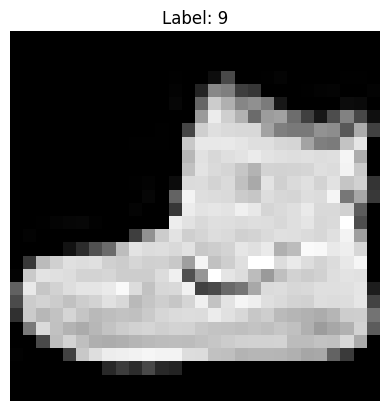

In [5]:
# 첫 번째 이미지와 레이블 가져오기
first_image = X_train[0]
first_label = y_train[0]

# 이미지 출력
plt.imshow(first_image, cmap='gray')
plt.title(f'Label: {first_label}')
plt.axis('off')  # 축 제거
plt.show()

이미지 전처리
이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [6]:
# 텐서로 변환 및 정규화
X_train = torch.Tensor(X_train) / 255.0
y_train = torch.Tensor(y_train).long()

print(X_train.shape)
print(y_train.shape)

# 텐서로 변환 및 정규화
X_test = torch.Tensor(X_test) / 255.0
y_test = torch.Tensor(y_test).long()

print(X_test.shape)
print(y_test.shape)

<ipython-input-6-8252a27dea59>:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  X_train = torch.Tensor(X_train) / 255.0


torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

데이터 증강: 훈련 데이터의 다양성을 증가시켜 모델의 일반화 능력을 향상시키는 기법 (좌우반전, 회전 적용)

차원 축소

차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.

그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.
PCA (주성분 분석)
: 데이터의 분산을 최대화하는 방향으로 새로운 축을 찾는 선형 차원 축소 기법, 데이터의 공분산 행렬을 계산하고, 고유값 분해를 통해 주성분을 찾음

주요 특징:

선형성: PCA는 선형 변환을 사용. 즉, 데이터가 선형적으로 분리될 수 있을 때 효과적
성능: 계산이 빠르고 대규모 데이터셋 처리에 적합
정보 손실: 차원을 줄이면서 일부 정보를 잃을 수 있지만, 최대한 분산을 유지
t-SNE (t-분포 확률적 이웃 임베딩)
: 고차원 데이터를 저차원으로 변환할 때, 고차원 공간에서의 유사성을 저차원 공간에서도 유지하도록 설계된 비선형 차원 축소 기법, 고차원 데이터 포인트 간의 거리(또는 확률)를 기반으로 저차원에서의 거리(또는 확률)를 조정

주요 특징:

비선형성: t-SNE는 비선형 변환을 사용하여 복잡한 데이터 구조를 잘 포착
계산 비용: PCA보다 계산 비용이 훨씬 높고, 대규모 데이터셋에서는 느림
클러스터링: t-SNE는 데이터의 클러스터를 잘 시각화함. 서로 가까운 데이터 포인트는 저차원에서도 가까이 위치

PCA

현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
# 데이터를 2D 형태로 변환 (60000, 28, 28) -> (60000, 784)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# PCA 적용
pca = PCA(n_components=50)
X_train_pca_50 = pca.fit_transform(X_train_scaled)

# 결과 확인
print("원본 훈련 데이터 차원:", X_train_reshaped.shape)
print("PCA 적용 후 훈련 데이터 차원:", X_train_pca_50.shape)

원본 훈련 데이터 차원: torch.Size([60000, 784])
PCA 적용 후 훈련 데이터 차원: (60000, 50)


PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [9]:
explained_variance = pca.explained_variance_ratio_
print("설명된 분산 비율:", explained_variance)

설명된 분산 비율: [0.22083547 0.14414633 0.05461176 0.05088686 0.04054887 0.03019511
 0.02747539 0.02313654 0.01692637 0.01318043 0.01170103 0.00962364
 0.00906441 0.00861006 0.00743008 0.00730325 0.00661558 0.00631515
 0.00621938 0.00584283 0.00523388 0.00511121 0.00473533 0.0045008
 0.00438704 0.00417086 0.0039834  0.00390545 0.00377665 0.00373526
 0.00363118 0.00351621 0.00336042 0.00330925 0.00328043 0.00317505
 0.00305205 0.00296661 0.00284695 0.00283068 0.00275586 0.00268136
 0.00262373 0.0025453  0.00247522 0.00240242 0.00237975 0.00228378
 0.00222071 0.00216055]


PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [10]:
# 원본 데이터로 재구성
X_train_reconstructed = pca.inverse_transform(X_train_pca_50)

# 재구성 오차 계산
reconstruction_error = np.mean((X_train_scaled - X_train_reconstructed) ** 2)
print("재구성 오차 (MSE):", reconstruction_error)

재구성 오차 (MSE): 0.1992940534909408


이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [11]:
# PCA 적용
pca = PCA(n_components=30)
X_train_pca_30 = pca.fit_transform(X_train_scaled)

# 결과 확인
print("원본 훈련 데이터 차원:", X_train_reshaped.shape)
print("PCA 적용 후 훈련 데이터 차원:", X_train_pca_30.shape)

원본 훈련 데이터 차원: torch.Size([60000, 784])
PCA 적용 후 훈련 데이터 차원: (60000, 30)


In [12]:
explained_variance = pca.explained_variance_ratio_
print("설명된 분산 비율:", explained_variance)

설명된 분산 비율: [0.22083547 0.14414633 0.05461176 0.05088686 0.04054887 0.03019511
 0.02747539 0.02313654 0.01692637 0.01318043 0.01170103 0.00962364
 0.00906441 0.00861006 0.00743008 0.00730325 0.00661558 0.00631515
 0.00621938 0.00584283 0.00523388 0.00511121 0.00473533 0.0045008
 0.00438704 0.00417086 0.0039834  0.00390545 0.00377665 0.00373526]


In [13]:
# 원본 데이터로 재구성
X_train_reconstructed = pca.inverse_transform(X_train_pca_30)

# 재구성 오차 계산
reconstruction_error = np.mean((X_train_scaled - X_train_reconstructed) ** 2)
print("재구성 오차 (MSE):", reconstruction_error)

재구성 오차 (MSE): 0.2557915676334351


데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

설명된 분산 비율: 차원을 줄일 때, 50차원에서 더 많은 주성분이 포함되므로, 데이터의 분산을 더 잘 설명할 수 있다. 일반적으로 더 많은 주성분을 사용하면 전체 데이터에서 차지하는 분산 비율이 증가하므로 50차원에서는 더 많은 정보를 보존할 수 있다.
재구성 오차 값: 30차원은 약 0.25의 재구성 오차 값을 가지고, 50차원은 약 0.20의 값을 가진다. 이는 50차원에서 원본 데이터를 더 잘 근사할 수 있음을 나타낸다.

마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [14]:
# PCA 적용
pca = PCA(n_components=2)
X_train_pca_2 = pca.fit_transform(X_train_scaled)

# 결과 확인
print("원본 훈련 데이터 차원:", X_train_reshaped.shape)
print("PCA 적용 후 훈련 데이터 차원:", X_train_pca_2.shape)

원본 훈련 데이터 차원: torch.Size([60000, 784])
PCA 적용 후 훈련 데이터 차원: (60000, 2)


In [15]:
explained_variance = pca.explained_variance_ratio_
print("설명된 분산 비율:", explained_variance)

설명된 분산 비율: [0.22083547 0.14414633]


In [16]:
# 원본 데이터로 재구성
X_train_reconstructed = pca.inverse_transform(X_train_pca_2)

# 재구성 오차 계산
reconstruction_error = np.mean((X_train_scaled - X_train_reconstructed) ** 2)
print("재구성 오차 (MSE):", reconstruction_error)

재구성 오차 (MSE): 0.6350182007523111


2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

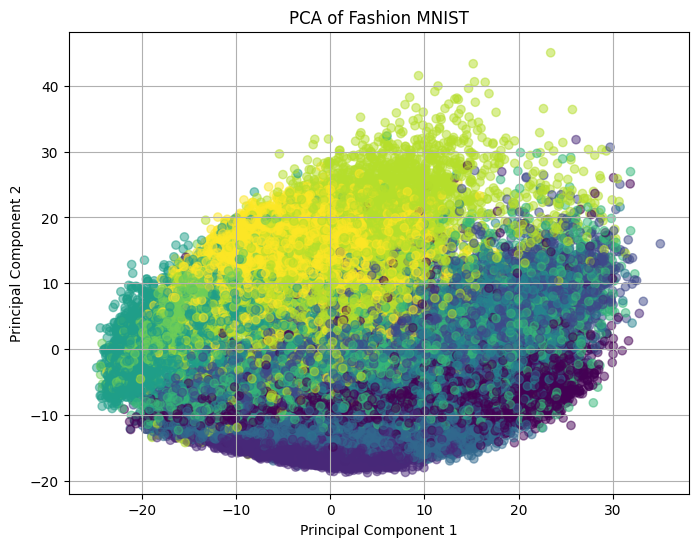

In [17]:
# 데이터 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=y_train, cmap='viridis', alpha=0.5)

# 색상 바 추가
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.gca().add_artist(legend1)

plt.title('PCA of Fashion MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

T-SNE
앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [18]:
from sklearn.manifold import TSNE

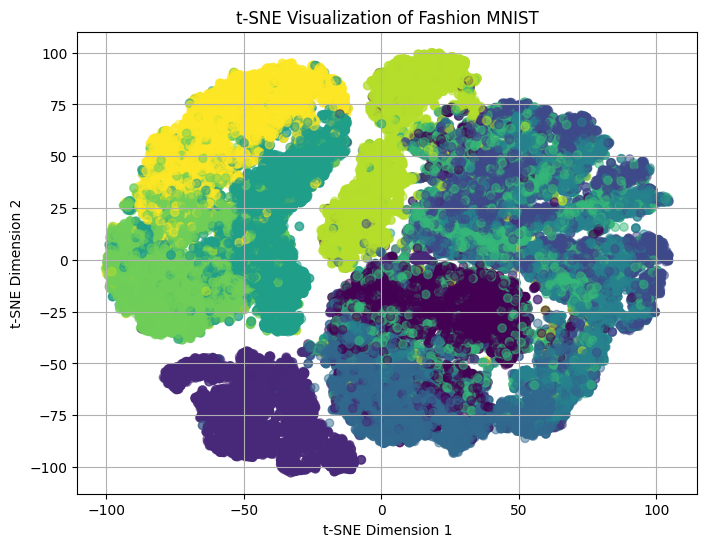

In [19]:
# t-SNE로 차원 축소
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_train_pca_50)

# 데이터 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.5)

# 색상 바 추가
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.gca().add_artist(legend1)

plt.title('t-SNE Visualization of Fashion MNIST')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid()
plt.show()